__How to compute 1.3 billion cosine distances on a laptop in ~35 seconds: pairwise_distances_chunked__
============================

## I found myself trying to compute pairwise cosine distances for a large list of high-dimensional vectors. <br /> It took a couple of (very bad solutions) until I found a reasonable one. <br /> It is pretty much a one-liner and you don't need to care about manually splitting/parallelizing things.<br/> This is a quick write-up for other people to save that time.

In [1]:
# Let's just import everything we need
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances_chunked
from tqdm import tqdm

In [2]:
# To get an idea, we have to compute this many values
n_vectors = 50_000
n_vectors * (n_vectors-1) / 2

1249975000.0

### The most straight forward to do this is with scipy/sklearn pairwise distances functions like this:

In [3]:
n_vectors = 5_000
n_dimensions = 300   

A = np.random.random(size=(n_vectors, n_dimensions))

%time D = cosine_distances(A)

CPU times: user 913 ms, sys: 360 ms, total: 1.27 s
Wall time: 389 ms


### So far, so good. But what happens if we want to compute for more vectors, say, 15 K?

In [4]:
n_vectors = 15_000

A = np.random.random(size=(n_vectors, n_dimensions))

%time D = cosine_distances(A)

CPU times: user 6.5 s, sys: 763 ms, total: 7.26 s
Wall time: 3.8 s


### And 30K, or 50K? We could suspect it is not going to scale (number of pairwise computations scales with the square of number of vectors).

### Let's look at that scaling a bit closer:

In [5]:
def evaluate_scaling(func, n_vectors_vals, n_dimensions=300):
    """return times of func execution for n_vectors_vals"""
    times = []
    for n_vectors in tqdm(n_vectors_vals):
        A = np.random.random(size=(n_vectors, n_dimensions))  
        st = time.time()
        D = func(A)
        times.append(time.time()-st)
        del D
    return times

def plot_scaling(n_vectors_vals, times):
    plt.plot(n_vectors_vals, times)
    plt.xlabel("number of vectors")
    plt.ylabel("time elapsed (seconds)")
    plt.grid(True, linestyle="--", alpha=0.7)

100%|██████████| 20/20 [00:49<00:00,  5.55s/it]


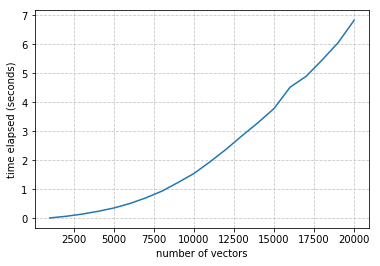

In [6]:
n_vectors_vals = np.arange(1000, 20001, 1000)
times = evaluate_scaling(cosine_distances, n_vectors_vals)

plot_scaling(n_vectors_vals, times)

### Let's estimate how long it would take for 50K vectors by extrapolating the performance (based on the quadratic scaling of number of pairs)

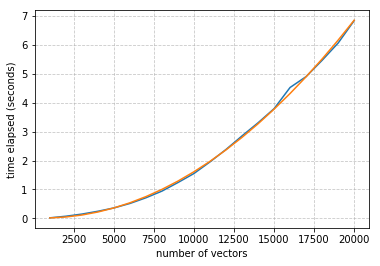

In [7]:
# Fit a 2nd degree polynomial and get the polynomial evaluator
fit = np.polyfit(n_vectors_vals, times, 2)  
poly = np.poly1d(fit)

# Check our fit
plot_scaling(n_vectors_vals, times)
plot_scaling(n_vectors_vals, poly(n_vectors_vals))

The fit looks correct, let's extrapolate:

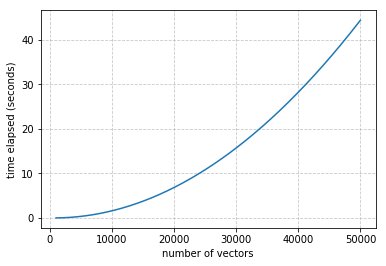

In [8]:
n_vectors_large = np.arange(1000, 50000)
plot_scaling(n_vectors_large, poly(n_vectors_large))

### Well that doesn't sound too bad... let's give it a try

In [9]:
n_vectors = 50_000

A = np.random.random(size=(n_vectors, n_dimensions))

D = cosine_distances(A)

#### Yes... you might have blown up your memory and forced your kernel to commit suicide.
#### If you are running this on a jupyter notebook you can see a message in the terminal similar to this:
```
[I 15:19:07.791 LabApp] KernelRestarter: restarting kernel (1/5), keep random ports
kernel 4055ff16-c49b-4a76-9068-e899d001fb85 restarted
```

#### (If 50K still works in your computer, just try a higher number, you'll get there pretty soon. My machine is fine until ~30K vectors)

### Bad solution idea: we might want to iterate and compute the values one by one instead of computing it with the cosine_distances function. <br /> Let's see

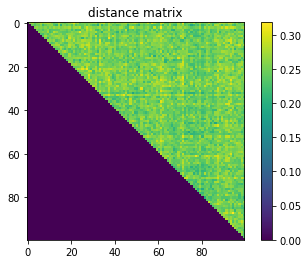

In [10]:
def cosine_distances_iter(A):
    n_vectors = A.shape[0]
    D = np.zeros((n_vectors, n_vectors))
    # D is symmetric, so we don't want to compute twice - just use upper diag indices
    for i, j in zip(*np.triu_indices(n_vectors, k=1)):
        D[i, j] = cosine(A[i], A[j])
    return D

n_vectors = 100
A = np.random.random(size=(n_vectors, n_dimensions))

D = cosine_distances_iter(A)
plt.imshow(D)
plt.colorbar()
plt.title("distance matrix");

### Now, how does it scale?

100%|██████████| 10/10 [00:49<00:00,  8.57s/it]


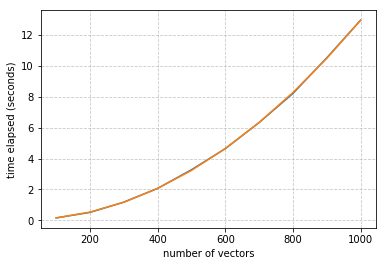

In [11]:
n_vectors_vals = np.arange(100, 1001, 100)
times = evaluate_scaling(cosine_distances_iter, n_vectors_vals)

# Fit a 2nd degree polynomial and get the polynomial evaluator
fit = np.polyfit(n_vectors_vals, times, 2)  
poly = np.poly1d(fit)

# Check our fit
plot_scaling(n_vectors_vals, times)
plot_scaling(n_vectors_vals, poly(n_vectors_vals))

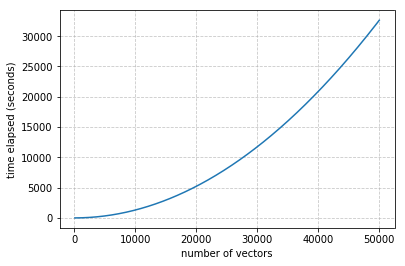

In [12]:
# Extrapolate
n_vectors_large = np.arange(100, 50001, 100)
plot_scaling(n_vectors_large, poly(n_vectors_large))

### Upss.. that is going to take a while. Conclusion: there must be a better way!
## Indeed: __pairwise_distances_chunked__ to the rescue!
### As the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_chunked.html) explains, this function creates a generator that will build up a distance matrix ___chunk by chunk___

In [13]:
n_vectors = 20000
n_dimensions = 300 

A = np.random.random(size=(n_vectors, n_dimensions))

chunk_generator = pairwise_distances_chunked(A, metric="cosine")
type(chunk_generator)

generator

In [14]:
chunk1 = next(chunk_generator)
chunk1.shape

(6710, 20000)

### As we see, calling the next method renders a __vertical slice__ (chunk) of the complete distance matrix until it exhaustes the generator. <br />  The size of each chunk will be figured out by sklearn.

In [15]:
chunk2 = next(chunk_generator)
print(chunk2.shape)

chunk3 = next(chunk_generator)
print(chunk3.shape)

print(chunk1.shape[0] + chunk2.shape[0] + chunk3.shape[0])

(6710, 20000)
(6580, 20000)
20000


### Back to our issue: 50K vectors

In [16]:
n_vectors = 50_000
n_dimensions = 300 
A = np.random.random(size=(n_vectors, n_dimensions))

chunk_generator = pairwise_distances_chunked(A, metric="cosine")       #  <--- this is what you came for :)

### Assuming the whole array fits in memory, we could collect all chunks and then concatenate them, like this:
```
D = np.vstack(chunk_generator)
```
### which is very nice, but will stop working with numpy 1.16, thus we need another container

In [17]:
# This might take a lot of RAM, so depending on your hardware you might just skip the concatenation
D = np.vstack([chunk for chunk in chunk_generator])   
D.shape

(50000, 50000)

# Voilà! That's it, we just computed the pairwise cosine distance for the _50 thousand_ vectors!
## If your matrix distance is too big such that cannot be concatenated into one array, then you can simply do whatever you need to with the individual chunks and save the intermediate results.
## For the sake of completeness:

100%|██████████| 9/9 [02:18<00:00, 24.15s/it]


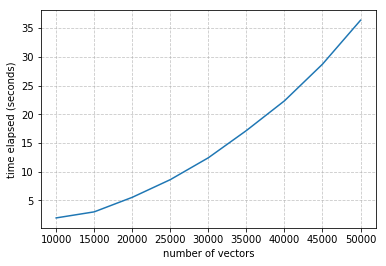

In [18]:
def cosine_distance_chunks(A):
    chunk_generator = pairwise_distances_chunked(A, metric="cosine")
    return np.vstack([chunk for chunk in chunk_generator])  

n_dimensions = 300 
n_vectors_vals = np.arange(10000, 50001, 5000)
times = evaluate_scaling(cosine_distance_chunks, n_vectors_vals)

plot_scaling(n_vectors_vals, times)

## Sanity check: compare to pure sklearn function

In [19]:
n_vectors = 30_000
n_dimensions = 300 
A = np.random.random(size=(n_vectors, n_dimensions))

D_skl = cosine_distances(A)
D_chunk = cosine_distance_chunks(A)

np.allclose(D_skl, D_chunk)

True

## Before we leave: __pairwise_distances_chunked__ has some parameters that can be pretty useful
- __n_jobs__ : distribute the computation across cores (though you might want to experiment a bit since ovehead might make it actually worse)
- __metric__ : compute other metrics than cosine distance, such as euclidean distance or even you own defined function.
   
## You can check the rest of them in the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_chunked.html).



# > Fin  :)